# #Masks Throughout COVID-19: A Twitter Sentiment Analysis

## Modeling

## Table of contents
1. [Introduction](#Introduction)
2. [The problem domain](#The-problem-domain)
3. [Required libraries](#Required-libraries)
4. [Step 1: Prepping the data](#Step-1:-Prepping-the-data)

    - [Train-test split](#Train-test-split)
    
    
5. [Step 2: Modeling](#Step-2:-Modeling)

    - [Parameter tuning](#Parameter-tuning)
    - [Train final model](#Train-final-model)


6. [Step 3: Reproducibility](#Step-3:-Reproducibility)

    - [NLP + Model version](#NLP-+-Model-version)
    - [Model only version](#Model-only-version)
    
    
7. [Conclusions](#Conclusions)
8. [Acknowledgements](#Acknowledgements)

## Introduction

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

After scraping Twitter with [Twint](https://github.com/twintproject/twint), [Eric Blander](https://github.com/EricB10) and [I](https://github.com/p-szymo) used natural language processing (NLP) techniques to analyze the sentiment of tweets relating to masks and coronavirus.

Through text processing, exploratory data analysis and feature engineering, we looked for insights into how important words, topics, and subjectivity relate to sentiment.

These steps, as well as answers to some initial questions about the data and the project, can be seen in the previous [notebook](03_nlp_features_eda.ipynb).

In this notebook, we will create predictive models that classify tweets as *negative*, *neutral*, or *positive*. This will help us provide further insight and confirm our findings made during EDA.

## The problem domain

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

Within the U.S., the official narrative on masks within the early days of the pandemic was surprising, in that government bodies were claiming that masks were [ineffective](https://twitter.com/surgeon_general/status/1233725785283932160?lang=en) in stopping the spread. Eventually, there was a stark shift in this narrative toward the necessity of wearing masks to "[protect each other](https://twitter.com/surgeon_general/status/1264166726230573057?lang=en)". The difference in tweets about masks by the Surgeon General in February (which were overwhelmingly negative) and his tweets in May (overwhelmingly positive) paint an important yet unfortunate picture of how officials dropped the ball in the pandemic's early days.

We began to wonder whether there was a similar shift within the country as a whole. How has the country's attitude toward masks changed since the early days of COVID-19, or has it remained relatively constant? We decided to look to Twitter to investigate if we could develop a clearer picture of the country's mood during these crucial and trying months.

## Required libraries

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

- **numpy**: Provides a fast numerical array structure and helper functions.
- **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
- **scikit-learn**: The essential Machine Learning package in Python.
- **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
- **seaborn**: Advanced statistical plotting library.
- **warnings**: A helpful package to ignore warnings that unnecessarily clutter the notebook.
- **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.

This notebook also uses some additional packages (some are only needed in the [Reproducibility](#Step-3:-Reproducibility) section) that you may have to install:

- **nltk**: The essential natural language processing package.
- **gensim**: A more specialized natural language processing package.
- **textblob**: A supplementary package to enhance the nltk package.
- **vaderSentiment**: A sentiment analysis tool based on human-compiled data.
- **wordcloud**: A library focused on plotting word frequencies.
- **pickle**: Package to save a file as a byte stream.
- **gzip**: Package to compress/unpack files.

Finally, included within the repository, and necessary to run this workbook, is:
- **[functions](functions.py)**: Custom functions that we built for this project.

Run the cell below to import all of the necessary packages.

In [1]:
# standard packages
import numpy as np
import pandas as pd

# visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('ticks')

# modeling packages
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, confusion_matrix, classification_report

# ignore sklearn warnings
# (code from: https://stackoverflow.com/questions/32612180/eliminating-warnings-from-scikit-learn)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# saving/loading packages
import gzip
import pickle

# custom functions and reload after editing
from functions import *
%load_ext autoreload
%autoreload 2

# Step 1: Prepping the data

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- Load target/features DataFrame and word vector DataFrame.
- Check for any highly correlated variables.
- Combine DataFrames.
- Train-test split.

In [2]:
# load dataframe
with gzip.open('data/jan_thru_may_labeled_mask_tweets_model_prepped.pkl', 'rb') as hello:
    df = pickle.load(hello)

# confirm shape
df.shape

(575949, 19)

In [3]:
# confirm columns look correct
df.columns

Index(['sentiment', 'clean_tweet', 'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4',
       'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9', 'subjectivity_score',
       'february', 'march', 'april', 'may', 'replies', 'likes'],
      dtype='object')

In [4]:
# load word vector dataframe
with gzip.open('data/data_vec.pkl', 'rb') as hello:
    vectors_df = pickle.load(hello)

# confirm shape
vectors_df.shape

(575949, 3566)

- Check for any highly correlated continuous variables.

In [5]:
# columns to check
cont_cols = [
    'lda_0', 'lda_1', 'lda_2',
    'lda_3', 'lda_4', 'lda_5', 
    'lda_6', 'lda_7', 'lda_8', 
    'lda_9', 'subjectivity_score'
       ]

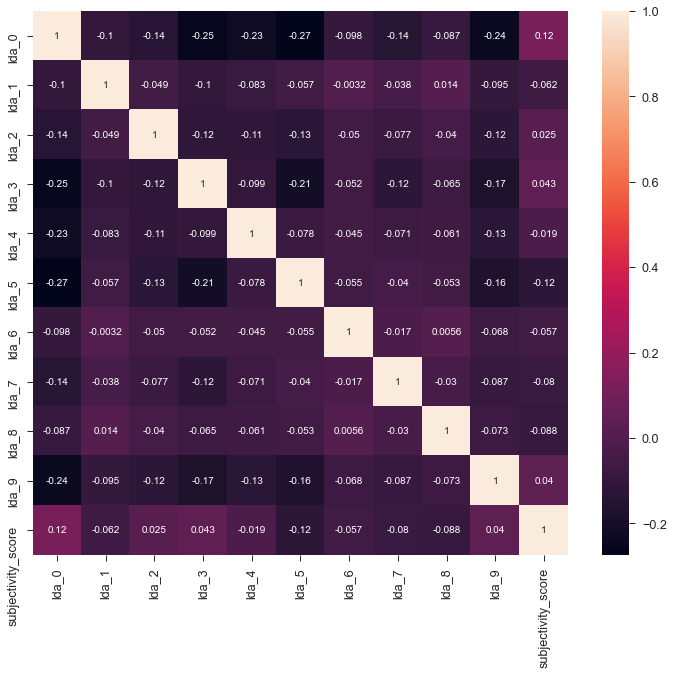

In [6]:
# plot correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df[cont_cols].corr(), annot=True);

- Looks good! So we can go ahead and include all of these.
- Next, we'll combine the DataFrames.

In [7]:
# list of columns to use as features
feature_cols = [
    'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4',
    'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9', 
    'subjectivity_score', 'february', 'march', 
    'april', 'may', 'replies', 'likes'
]

In [8]:
%%time

# combine features columns and word vectors dataframe
X = pd.concat([df[feature_cols], vectors_df], axis=1)
y = df['sentiment']

X.shape, y.shape

CPU times: user 51.5 s, sys: 19.4 s, total: 1min 10s
Wall time: 1min 14s


((575949, 3583), (575949,))

## Train-test split

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- Use 70% of our data as a training set and 30% as a testing set.
- Since we want to see if our engineered features improve our models beyond those using only word vectors, we'll also create separate vector-only training and testing sets.
- Our data is all on the same scale (between 0 and 1), so no scaler is necessary.

In [9]:
%%time

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

# create vectors-only training and test sets (removing the first 17 columns)
X_train_vec = X_train.iloc[:,17:]
X_test_vec = X_test.iloc[:,17:]

X_train.shape, X_test.shape, X_train_vec.shape, X_test_vec.shape

CPU times: user 41.4 s, sys: 47.9 s, total: 1min 29s
Wall time: 1min 48s


((403164, 3583), (172785, 3583), (403164, 3566), (172785, 3566))

# Step 2: Modeling

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- We'll test out untuned Naive Bayes (Bernoulli and Multinomial) and Decision Tree models on both our vectors-only sets and vectors-plus-features sets.
- Because the dataset is so large (in both rows and columns) and cross-validation is so intensive, we are only able to use train-test split to cross-validate.
- After an initial run through our basic models, we'll tune parameters.
- Finally, we can train and save a final model.

### Bernoulli Naive Bayes - vectors only

⏰ *NOTE: This will take a few minutes to run.*

In [10]:
%%time

# create Bernoulli Naive Bayes object
bnb_vec = BernoulliNB()

# train model
benaba_vec = bnb_vec.fit(X_train_vec, y_train)

# predict on train and test data
y_train_pred_bnb_vec = benaba_vec.predict(X_train_vec)
y_test_pred_bnb_vec = benaba_vec.predict(X_test_vec)

CPU times: user 2min 30s, sys: 50 s, total: 3min 20s
Wall time: 3min 22s


In [11]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_bnb_vec)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_bnb_vec, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_bnb_vec, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_bnb_vec, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_bnb_vec)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_bnb_vec, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_bnb_vec, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_bnb_vec, average="weighted")}')


print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_bnb_vec, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_bnb_vec))

-----TRAIN-----
Accuracy: 0.7157608318203014
F1 score: 0.7176953642255267
Recall: 0.7157608318203014
Precision: 0.7257952387590993

-----TEST-----
Accuracy: 0.7127528431287438
F1 score: 0.7147691967836526
Recall: 0.7127528431287438
Precision: 0.7228616573206086

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.74      0.70      0.72     66413
    positive       0.59      0.76      0.66     34605
     neutral       0.78      0.71      0.74     71767

    accuracy                           0.71    172785
   macro avg       0.70      0.72      0.71    172785
weighted avg       0.72      0.71      0.71    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[46191  9548 10674]
 [ 4383 26204  4018]
 [12124  8885 50758]]


- Not bad! Very well fit and decent F1 scores, though it struggles a bit in identifying *positive* tweets.
- Let's take a quick look at important features and confusion matrices.

#### Feature importances

In [12]:
# function to print top 10 features for each class
print_nb_features(
            benaba_vec,
            X_train_vec,
            ['positive', 'neutral', 'negative']
        )

Positive tweets:
#wholesale, okhand, #sale, smilingfacewith3, faceblowingakiss, #healthy, #safe, purpleheart, blueheart, twohearts

Neutral tweets:
#love, celebrate, smilingfacewithheart, smilingfacewith3, okhand, incompetent, incompetence, improve, violent, loss

Negative tweets:
iniran, assault, thief, incompetence, suicide, germany's, #fight, fails, threatens, declares



#### Confusion matrix

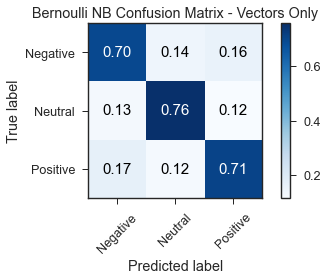

In [13]:
# plot confusion matrix - normalized
cm_benaba = confusion_matrix(y_test, y_test_pred_bnb_vec)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_benaba, classes, normalize=True,
                      title='Bernoulli NB Confusion Matrix - Vectors Only', cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/bnb_vec_cm.png', transparent=True, bbox_inches='tight', dpi=100)

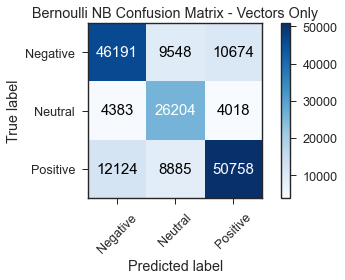

In [14]:
# plot confusion matrix - quantity
cm_benaba = confusion_matrix(y_test, y_test_pred_bnb_vec)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_benaba, classes, normalize=False,
                      title='Bernoulli NB Confusion Matrix - Vectors Only', cmap=plt.cm.Blues)

- It's interesting that hashtags and emojis are so important for *positive* and *neutral* tweets, but not *negative* tweets.
- Could it be that tweets with these "words" tend to be more *positive*, or does the VADER sentiment analyzer weight them more positively? It's difficult to tell here, but maybe in the future, we can try removing hashtags and emojis and see how that affects our results.

### Bernoulli Naive Bayes - numerical data + vectors

⏰ *NOTE: This will take a few minutes to run.*

In [15]:
%%time

# create Bernoulli Naive Bayes object
bnb_combo = BernoulliNB()

# train model
benaba_combo = bnb_combo.fit(X_train, y_train)

# predict on corresponding train and test data
y_pred_train_bnb_combo = benaba_combo.predict(X_train)
y_pred_test_bnb_combo = benaba_combo.predict(X_test)

CPU times: user 2min 45s, sys: 1min 11s, total: 3min 56s
Wall time: 4min 7s


In [16]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_pred_train_bnb_combo)}')
print(f'F1 score: {f1_score(y_train, y_pred_train_bnb_combo, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_pred_train_bnb_combo, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_pred_train_bnb_combo, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_pred_test_bnb_combo)}')
print(f'F1 score: {f1_score(y_test, y_pred_test_bnb_combo, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_pred_test_bnb_combo, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_pred_test_bnb_combo, average="weighted")}')


print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_pred_test_bnb_combo, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_pred_test_bnb_combo))

-----TRAIN-----
Accuracy: 0.6254229048228512
F1 score: 0.6347419976743295
Recall: 0.6254229048228512
Precision: 0.6747955930823033

-----TEST-----
Accuracy: 0.6233237838932778
F1 score: 0.6325810019992972
Recall: 0.6233237838932778
Precision: 0.673085341549466

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.72      0.59      0.65     66413
    positive       0.42      0.75      0.54     34605
     neutral       0.75      0.59      0.66     71767

    accuracy                           0.62    172785
   macro avg       0.63      0.64      0.62    172785
weighted avg       0.67      0.62      0.63    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[39274 17258  9881]
 [ 4331 25937  4337]
 [10754 18523 42490]]


- Wow! Much worse, with similar problems identifying *positive* tweets.
- A quick look at important features below shoes no major differences.
- The confusion matrices show that *neutral* tweets are still the most effectively predicted, without any loss by using the other features.

#### Feature importances

In [17]:
# function to print top 10 features for each class
print_nb_features(
            benaba_combo,
            X_train,
            ['positive', 'neutral', 'negative']
        )

Positive tweets:
#wholesale, #sale, okhand, faceblowingakiss, smilingfacewith3, #healthy, #safe, purpleheart, smilingfacewithheart, #love

Neutral tweets:
improve, #love, smilingfacewith3, smilingfacewithheart, celebrate, okhand, incompetence, incompetent, creative, illegal

Negative tweets:
iniran, assault, thief, suicide, incompetence, germany's, fails, #fight, threatens, violence



#### Confusion matrix

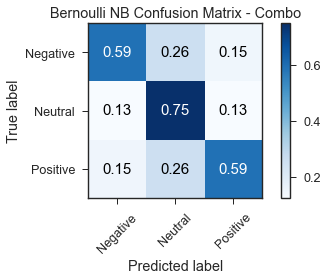

In [18]:
# plot confusion matrix - normalized
cm_benaba = confusion_matrix(y_test, y_pred_test_bnb_combo)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_benaba, classes, normalize=True,
                      title='Bernoulli NB Confusion Matrix - Combo', cmap=plt.cm.Blues)

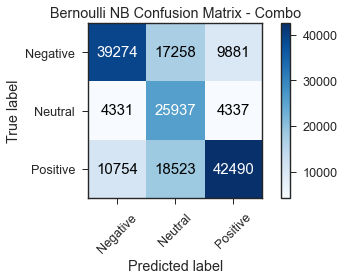

In [19]:
# plot confusion matrix - quantity
cm_benaba = confusion_matrix(y_test, y_pred_test_bnb_combo)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_benaba, classes, normalize=False,
                      title='Bernoulli NB Confusion Matrix - Combo', cmap=plt.cm.Blues)

### Multinomial Naive Bayes - vectors only

In [20]:
%%time

# create Multinomial Naive Bayes object
mnb_vec = MultinomialNB()

# train model
munaba_vec = mnb_vec.fit(X_train_vec, y_train)

# predict on corresponding train and test data
y_train_pred_mnb_vec = munaba_vec.predict(X_train_vec)
y_test_pred_mnb_vec = munaba_vec.predict(X_test_vec)

CPU times: user 24 s, sys: 8.05 s, total: 32 s
Wall time: 22.8 s


In [21]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_mnb_vec)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_mnb_vec, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_mnb_vec, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_mnb_vec, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_mnb_vec)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_mnb_vec, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_mnb_vec, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_mnb_vec, average="weighted")}')

print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_mnb_vec, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_mnb_vec))

-----TRAIN-----
Accuracy: 0.692006230715044
F1 score: 0.6774887034891885
Recall: 0.692006230715044
Precision: 0.6965605413145178

-----TEST-----
Accuracy: 0.688057412391122
F1 score: 0.6733511536832583
Recall: 0.688057412391122
Precision: 0.6918766959418424

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.70      0.75      0.72     66413
    positive       0.72      0.33      0.45     34605
     neutral       0.67      0.80      0.73     71767

    accuracy                           0.69    172785
   macro avg       0.70      0.63      0.64    172785
weighted avg       0.69      0.69      0.67    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[49856  2441 14116]
 [ 9189 11531 13885]
 [12122  2146 57499]]


- Similar results but worse across the board.
- We'll see if our features improve it.

### Multinomial Naive Bayes - numerical data + vectors

In [22]:
%%time

# create Multinomial Naive Bayes object
mnb_combo = MultinomialNB()

# train model
munaba_combo = mnb_combo.fit(X_train, y_train)

# predict on corresponding train and test data
y_train_pred_mnb_combo = munaba_combo.predict(X_train)
y_test_pred_mnb_combo = munaba_combo.predict(X_test)

CPU times: user 35.7 s, sys: 31 s, total: 1min 6s
Wall time: 1min 6s


In [23]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_mnb_combo)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_mnb_combo, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_mnb_combo, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_mnb_combo, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_mnb_combo)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_mnb_combo, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_mnb_combo, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_mnb_combo, average="weighted")}')

print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_mnb_combo, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_mnb_combo))

-----TRAIN-----
Accuracy: 0.6970711670684883
F1 score: 0.6885496709793402
Recall: 0.6970711670684883
Precision: 0.6990540461976077

-----TEST-----
Accuracy: 0.6945741817866135
F1 score: 0.6860664695731379
Recall: 0.6945741817866135
Precision: 0.6962108790803943

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.70      0.74      0.72     66413
    positive       0.71      0.42      0.52     34605
     neutral       0.69      0.79      0.73     71767

    accuracy                           0.69    172785
   macro avg       0.70      0.65      0.66    172785
weighted avg       0.70      0.69      0.69    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[49245  3202 13966]
 [ 8829 14390 11386]
 [12748  2642 56377]]


- Interesting! Actually a very slight increase here, but still not enough to beat our first model.

### Decision Tree - vectors only - untuned

⏰ *NOTE: Next cell took me 1 hour and 13 minutes to run.*

In [24]:
%%time

# basic decision tree with class weights balanced
tree_vec = DecisionTreeClassifier(class_weight='balanced', random_state=99)

# fit training data
tree_vec.fit(X_train_vec, y_train)

# predict on train and test data
y_train_pred_tree_vec = tree_vec.predict(X_train_vec)
y_test_pred_tree_vec = tree_vec.predict(X_test_vec)

CPU times: user 1h 12min 29s, sys: 20.8 s, total: 1h 12min 50s
Wall time: 1h 12min 58s


In [25]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_tree_vec)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_tree_vec, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_tree_vec, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_tree_vec, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_tree_vec)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_tree_vec, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_tree_vec, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_tree_vec, average="weighted")}')

print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_tree_vec, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_tree_vec))

-----TRAIN-----
Accuracy: 0.9960685973946086
F1 score: 0.9960746024747931
Recall: 0.9960685973946086
Precision: 0.996101175153244

-----TEST-----
Accuracy: 0.7465173481494343
F1 score: 0.7462871524382707
Recall: 0.7465173481494343
Precision: 0.7464430597980899

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.74      0.72      0.73     66413
    positive       0.75      0.80      0.77     34605
     neutral       0.76      0.75      0.75     71767

    accuracy                           0.75    172785
   macro avg       0.75      0.75      0.75    172785
weighted avg       0.75      0.75      0.75    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[47868  4712 13833]
 [ 3512 27614  3479]
 [13743  4519 53505]]


- Well, it took over an hour to run, but it gave us a decent 3% bump in F1 score. It appears that almost all of this can be attributed to much more accurate predictions of the *positive* class.
- Unsurprisingly, the model is incredibly overfit, as Decision Trees often are. We'll see if we can improve the fit (so that it can better generalize on unseen data) later on, in the [parameter tuning](#Parameter-tuning) section.
- Let's look at which words were important, as well as some confusion matrices.

#### Feature importances

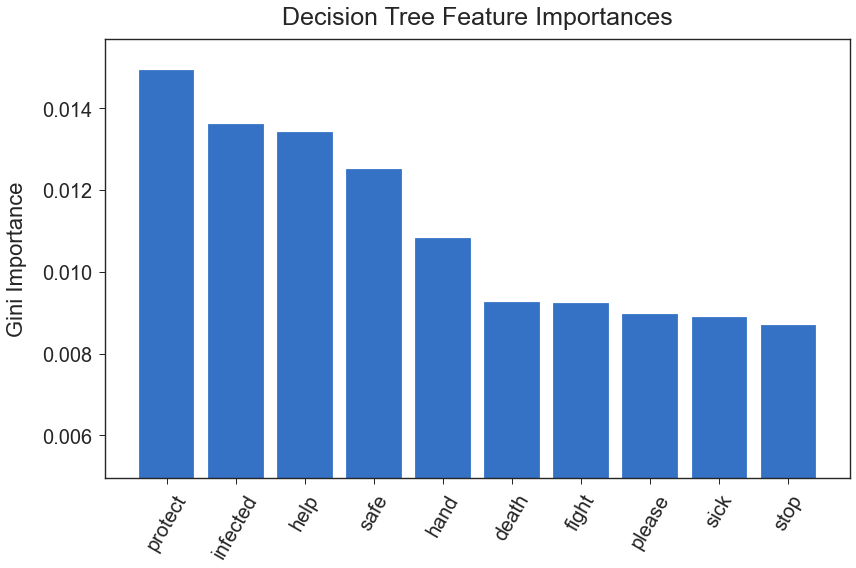





[('protect', 0.014938533998980182), ('infected', 0.013619865087923937), ('help', 0.013426661271167996), ('safe', 0.012514449949199284), ('hand', 0.010826479841317264), ('death', 0.009258622591997516), ('fight', 0.009245948686294093), ('please', 0.008956061314302148), ('sick', 0.008904573914449404), ('stop', 0.00869231271083583)]


In [26]:
# plot and print 10 most important features
plot_tree_features(
                    tree_vec,
                    X_train_vec,
                    # uncomment to save
                    file_name='charts/dt_vec_untuned_features.png'
                )

- An interesting mix of words that were frequent in *positive* tweets (*protect*, *help*, *hand*, and *please* were in the top 5 most frequent words for this class) and *negative* tweets (*infected*, *death*, and *stop* were in the top 5 for this class).
- *Fight* was not a very commonly used word and didn't appear in any top 25 list.

#### Confusion matrix

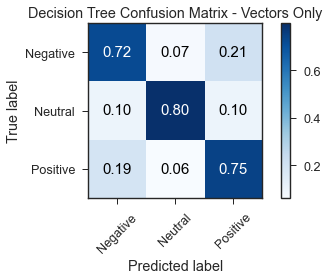

In [27]:
# plot confusion matrix - normalized
cm_tree = confusion_matrix(y_test, y_test_pred_tree_vec)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=True,
                      title='Decision Tree Confusion Matrix - Vectors Only', cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/dt_vec_untuned_cm.png', transparent=True, bbox_inches='tight', dpi=100)

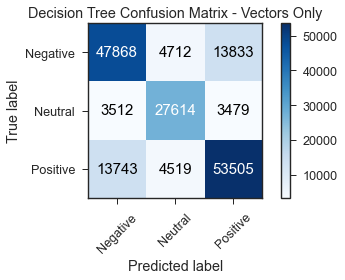

In [28]:
# plot confusion matrix - quantity
cm_tree = confusion_matrix(y_test, y_test_pred_tree_vec)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=False,
                      title='Decision Tree Confusion Matrix - Vectors Only', cmap=plt.cm.Blues)

### Decision Tree - numerical data + vectors - untuned

⏰ *NOTE: Next cell took me 30 minutes to run.*

In [29]:
%%time

# basic decision tree with class weights balanced
tree_combo = DecisionTreeClassifier(class_weight='balanced', random_state=99)

# fit training data
tree_combo.fit(X_train, y_train)

# predict on train and test data
y_train_pred_tree_combo = tree_combo.predict(X_train)
y_test_pred_tree_combo = tree_combo.predict(X_test)

CPU times: user 26min 56s, sys: 35.8 s, total: 27min 32s
Wall time: 27min 45s


In [30]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_tree_combo)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_tree_combo, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_tree_combo, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_tree_combo, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_tree_combo)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_tree_combo, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_tree_combo, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_tree_combo, average="weighted")}')

print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_tree_combo, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_tree_combo))

-----TRAIN-----
Accuracy: 0.9990772985683245
F1 score: 0.9990777286787124
Recall: 0.9990772985683245
Precision: 0.9990798038289886

-----TEST-----
Accuracy: 0.6711693723413491
F1 score: 0.6713034123480605
Recall: 0.6711693723413491
Precision: 0.671738010134415

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.66      0.66      0.66     66413
    positive       0.64      0.68      0.66     34605
     neutral       0.70      0.68      0.69     71767

    accuracy                           0.67    172785
   macro avg       0.67      0.67      0.67    172785
weighted avg       0.67      0.67      0.67    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[43573  6827 16013]
 [ 5777 23429  5399]
 [16341  6460 48966]]


- Our worst model yet! Features other than the words themselves seem to not be very helpful in these models. 

#### Feature importances

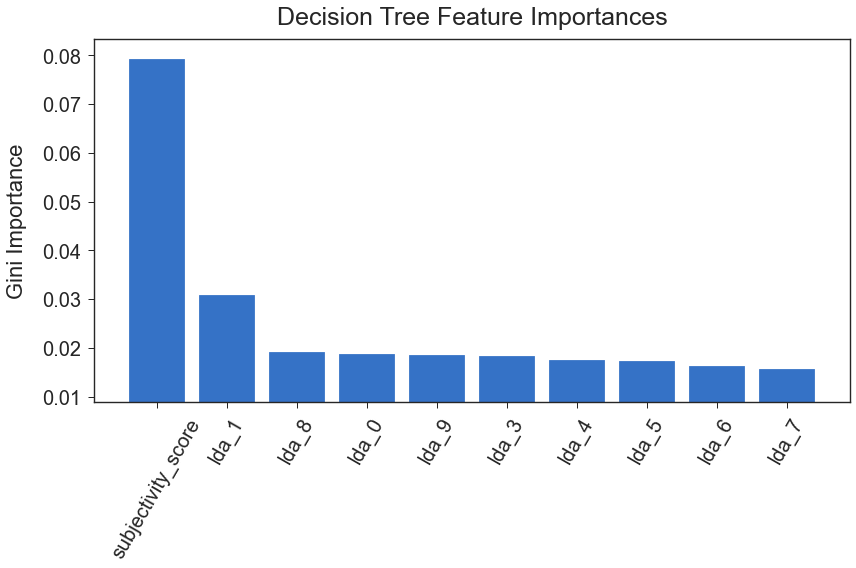





[('subjectivity_score', 0.0792855920438909), ('lda_1', 0.030806703968522618), ('lda_8', 0.01926153028717357), ('lda_0', 0.01882909698035492), ('lda_9', 0.018546198836421605), ('lda_3', 0.01826168129087734), ('lda_4', 0.017448784510997864), ('lda_5', 0.017380610967211208), ('lda_6', 0.016292162384616726), ('lda_7', 0.015711377670566372)]


In [47]:
# plot and print 10 most important features
plot_tree_features(
                    tree_combo,
                    X_train
                )

- Imagine that! The top 10 features are all ones that we engineered. Unfortunately, that doesn't matter much, since we won't be using this model, on account of its poor performance overall.
- Still, let's look at the distribution of predictions with some confusion matrices.

#### Confusion matrices

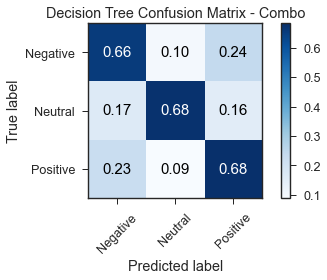

In [32]:
# plot confusion matrix - normalized
cm_tree = confusion_matrix(y_test, y_test_pred_tree_combo)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=True,
                      title='Decision Tree Confusion Matrix - Combo', cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/dt_combo_untuned_cm.png', transparent=True, bbox_inches='tight', dpi=100)

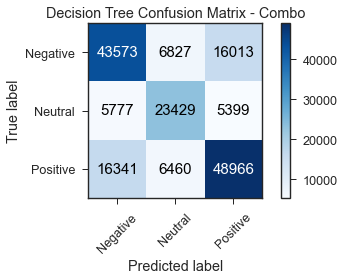

In [33]:
# plot confusion matrix - quantity
cm_tree = confusion_matrix(y_test, y_test_pred_tree_combo)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=False,
                      title='Decision Tree Confusion Matrix - Combo', cmap=plt.cm.Blues)

## Parameter tuning

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- Because our model is so overfit, we have to try to tune some parameters to see if we can still achieve a decent F1 score while still being able to generalize on unseen data.
- Normally, we would cross-validate using sklearn's cross_val_score, but because our dataset has so many rows and columns, we will have to stick with train-test split (which still takes a long time) and use trial and error on various parameters.
- Given the time and computing power these models require, we'll limit this section to the vectors-only version of the Decision Tree models.

### Finding the best alpha

- Using sklearn's [tutorial](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html) as my guide, I can use a cost function to find a good alpha value that can prune my tree after it is created.
- Essentially, this should help me to trim off any leaves and leaf nodes that lead to overfitting.
- Again, given the size of the dataset, I cannot run through the whole process shown in the tutorial, but I can get a decent idea in this first step. I'll be looking for a value with minimal impurity that isn't 0.

⏰ *NOTE: Next cell took me 1 hour and 9 minutes to run.*

In [34]:
%%time

# instantiate classifier
clf = DecisionTreeClassifier(class_weight='balanced', random_state=99)

# run cost function
path = clf.cost_complexity_pruning_path(X_train_vec, y_train)

# save necessary values
ccp_alphas, impurities = path.ccp_alphas, path.impurities

CPU times: user 1h 10min 47s, sys: 12 s, total: 1h 10min 59s
Wall time: 1h 11min 5s


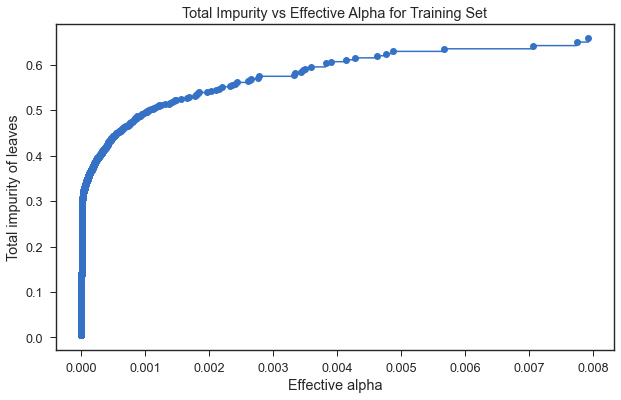

In [35]:
# plot results
plt.figure(figsize=(10,6))
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle='steps-post')
plt.xlabel('Effective alpha')
plt.ylabel('Total impurity of leaves')
plt.title('Total Impurity vs Effective Alpha for Training Set');

- Interesting, this looks almost like an elbow plot. Clearly a value closer to 0 will be best.
- To save time and space, I'll cut straight to the alpha that worked best for me, though I did have to do some trial and error.

### Decision Tree - vectors only - tuned

⏰ *NOTE: Next cell took me 1 hour and 14 minutes to run.*

In [36]:
%%time

# basic decision tree with class weights balanced
tree_vec_tuned = DecisionTreeClassifier(class_weight='balanced', ccp_alpha=0.00005, random_state=99)

# fit training data
tree_vec_tuned.fit(X_train_vec, y_train)

# predict on train and test data
y_train_pred_tree_vec_tuned = tree_vec_tuned.predict(X_train_vec)
y_test_pred_tree_vec_tuned = tree_vec_tuned.predict(X_test_vec)

CPU times: user 1h 9min 51s, sys: 20.1 s, total: 1h 10min 11s
Wall time: 1h 10min 19s


In [37]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_tree_vec_tuned)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_tree_vec_tuned, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_tree_vec_tuned, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_tree_vec_tuned, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_tree_vec_tuned)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_tree_vec_tuned, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_tree_vec_tuned, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_tree_vec_tuned, average="weighted")}')

print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_tree_vec_tuned, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_tree_vec_tuned))

-----TRAIN-----
Accuracy: 0.7716289152801341
F1 score: 0.7705546138094281
Recall: 0.7716289152801341
Precision: 0.7729631745492118

-----TEST-----
Accuracy: 0.7684463350406575
F1 score: 0.7673779998241845
Recall: 0.7684463350406575
Precision: 0.7699557871030053

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.78      0.70      0.74     66413
    positive       0.74      0.87      0.80     34605
     neutral       0.77      0.78      0.78     71767

    accuracy                           0.77    172785
   macro avg       0.77      0.78      0.77    172785
weighted avg       0.77      0.77      0.77    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[46709  5526 14178]
 [ 2001 29954  2650]
 [10798  4856 56113]]


- Wow! Look at that fit! A nearly perfect fit and all of our metrics actually went up.
- Our F1 score has increased by over 5% from the basic Naive Bayes model.
- Let's see if our feature importances were effected.

#### Feature importances

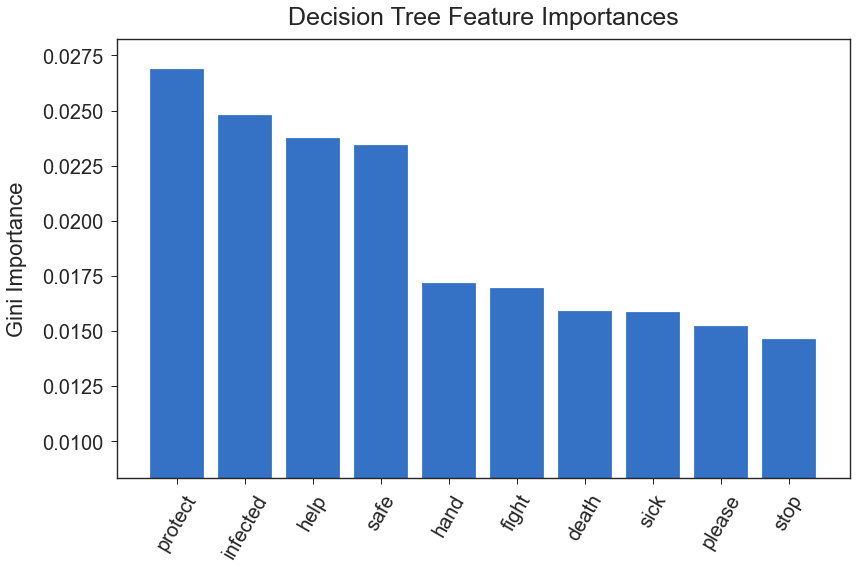





[('protect', 0.02688040431353014), ('infected', 0.02480419541060165), ('help', 0.023758951122541436), ('safe', 0.023448878454596568), ('hand', 0.01719576299576432), ('fight', 0.016959453005094452), ('death', 0.015931170445017365), ('sick', 0.015860411565487776), ('please', 0.015242529702725067), ('stop', 0.014622477888725487)]


In [38]:
# plot and print 10 most important features
plot_tree_features(
                    tree_vec_tuned,
                    X_train_vec,
                    # uncomment to save
                    file_name='charts/dt_vec_tuned_features.png'
                )

- Interestingly, the feature importance value almost doubled for each one shown here! But other than that, they are  the same words, albeit with some small changes in the order.
- Let's look at the distribution of predictions.

#### Confusion matrices

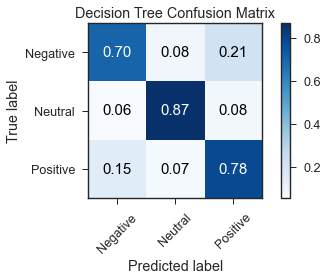

In [39]:
# plot confusion matrix - normalized
cm_tree = confusion_matrix(y_test, y_test_pred_tree_vec_tuned)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=True,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/dt_vec_tuned_cm.png', transparent=True, bbox_inches='tight', dpi=100)

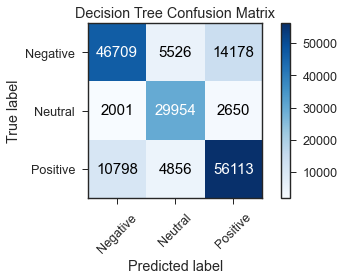

In [40]:
# plot confusion matrix - quantity
cm_tree = confusion_matrix(y_test, y_test_pred_tree_vec_tuned)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=False,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

- A decently stronger performance among *positive* and *neutral* tweets. The accuracy of *negative* predictions dropped, but the F1 score for all classes stayed relatively the same.
- Furthermore, the overall F1 score increased over 5% from the basic Naive Bayes model, so this model seems worth the time (again, depending on the use case).

#### BONUS: Comparing tree complexities

- Below, I compare the complexity of the untuned, overfit version with the tuned, well-fit version

In [41]:
# print attributes of untuned tree
print('-----UNTUNED-----')
print(f'Max depth:   {tree_vec.tree_.max_depth}')
print(f'Node count:  {tree_vec.tree_.node_count}')
print(f'# of leaves: {tree_vec.tree_.n_leaves}')

print('\n------TUNED------')
print(f'Max depth:   {tree_vec_tuned.tree_.max_depth}')
print(f'Node count:  {tree_vec_tuned.tree_.node_count}')
print(f'# of leaves: {tree_vec_tuned.tree_.n_leaves}')

-----UNTUNED-----
Max depth:   3288
Node count:  125889
# of leaves: 62945

------TUNED------
Max depth:   630
Node count:  1689
# of leaves: 845


- That's quite a pruning! And it actually increased performance. Perhaps combining this with some pre-pruning techniques (setting a ```max_depth``` or ```min_samples_leaf```) could save us some time on the front end; but for now, I'm happy with this.

## Train final model

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- Let's train a final model and save.

⏰ *NOTE: Next cell took me 1 hour and 15 minutes to run.*

In [ ]:
%%time

# re-create features and target
X_final = vectors_df.copy()
y = df['sentiment']

# basic decision tree with class weights balanced
final_model = DecisionTreeClassifier(class_weight='balanced', ccp_alpha=0.00005, random_state=99)

# fit model on all the data
final_model.fit(X_final, y)

# predict on train and test data
y_preds = tree_vec_tuned.predict(X_final)

print(f'F1 score: {f1_score(y, y_preds, average="weighted")}')

#### 💾 Save/Load the final model

In [ ]:
# uncomment to save
with gzip.open('data/final_model.pkl', 'wb') as goodbye:
    pickle.dump(final_model, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/final_model.pkl', 'rb') as hello:
#     final_model = pickle.load(hello)

# Step 3: Reproducibility

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- Below are the required packages and other information.

In [44]:
%load_ext watermark
%watermark -a 'Joshua Szymanowski' -nmv --packages numpy,pandas,sklearn,scipy,matplotlib,seaborn,nltk,gensim,textblob,pickle,gzip

Joshua Szymanowski Wed Aug 05 2020 

CPython 3.6.9
IPython 7.8.0

numpy 1.18.2
pandas 1.0.3
sklearn 0.0
scipy 1.4.1
matplotlib 3.2.1
seaborn 0.10.0
nltk 3.4.5
gensim 3.7.3
textblob 0.15.3
pickle unknown
gzip unknown

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


## NLP + Model version

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

The following code includes all of the important work from the previous [notebook](03_nlp_features_eda.ipynb), but is not necessary to create the final model (which this code also does).

Refer to the next [section](#Model-only-version) for the code that reproduces the model only.

*NOTE: read the commented code carefully if you wish to create your own LDA topics.*

⏰ *NOTE: Next cell will take several hours to run.*

In [ ]:
%%time

# standard packages
import numpy as np
import pandas as pd

# visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('ticks')

# text processing/nlp packages
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

# modeling packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, confusion_matrix, classification_report

# saving/loading packages
import gzip
import pickle

# custom functions
from functions import *

# load dataframe
with gzip.open('data/jan_thru_may_labeled_mask_tweets.pkl', 'rb') as hello:
    df = pickle.load(hello)
    
# create stop words list
stop_words = stopwords.words('english')
# add search term words and hashtags to the list
stop_words += ['mask', '#mask',
               'masks', '#masks',
               'face', '#face',
               'facemask', '#facemask',
               'facemasks', '#facemasks', 
               'covid', '#covid',
               'covid19', '#covid19',
               'corona', '#corona',
               'coronavirus', '#coronavirus',
               'rona', '#rona',
               'virus', '#virus',
               'viral', '#viral',
               'viruses', '#viruses']
# very common/conflicting stop words discovered during eda
eda_stop_words = ['wear', 'wearing', 'get', 'one', 'people',
                  'us', 'like', 'n95', 'go', 'going', 'would', 
                  'surgical', 'via', 'also', 'use', 'even', 'know']
stop_words += eda_stop_words

# create column of processed text
df['clean_tweet'] = df['tweet'].apply(lambda x: clean_text(x, stop_words))

# custom pattern to tokenize words -- includes hashtags, words with numbers, and contractions
pattern = "(#?[a-zA-Z]+[0-9]*(?:'[a-z]+)?)"

# instantiate a document-term matrix using TfidfVectorizer
# only take words with at least 250 appearances
tf_idf = TfidfVectorizer(min_df=250, token_pattern=pattern)

# run vectorizor
data_tf_idf = tf_idf.fit_transform(df.clean_tweet)

# convert to DataFrame
data_vec = pd.DataFrame(data_tf_idf.toarray(), columns=tf_idf.get_feature_names())

    #----IMPORTANT NOTE----#
# Our corpus has changed slightly after updating the clean_text function, 
# so we will be loading the original corpus, in order to keep our original topics.
# If you wish to create new topics, uncomment commented code below.

# # one of the required inputs is a term-document matrix
# tdm = data_vec.transpose()
# tdm.head()

# # put the term-document matrix into a new gensim format, 
# # from df ==> sparse matrix ==> gensim corpus
# # NOTE: MAY TAKE A FEW MINUTES
# sparse_counts = csr_matrix(tdm)
# corpus = Sparse2Corpus(sparse_counts)

# # gensim also requires dictionary of the all terms and their respective location in the term-document matrix
# id2word = dict((v, k) for k, v in tf_idf.vocabulary_.items())

# # create the topics
# lda = LdaModel(
#                 corpus=corpus, 
#                 id2word=id2word, 
#                 num_topics=10, 
#                 passes=100, 
#                 iterations=100
#             )

    #----IMPORTANT NOTE----#
# If you chose to create your own corpus/topics, comment out these cells

# load gensim corpus
with gzip.open('data/gensim_corpus_orig.pkl', 'rb') as hello_c:
    corpus = pickle.load(hello_c)
# load vocab location dictionary
with gzip.open('data/gensim_id2word_orig.pkl', 'rb') as hello_i:
    id2word = pickle.load(hello_i)
# load topics
with gzip.open('models/lda_10topics_100passes.pkl', 'rb') as hello:
    lda = pickle.load(hello)
#-----------------------------#

# corpus from LDA model
corpus_transformed = lda[corpus]

# convert lda tuples to dictionary
lda_topics_dict = [dict(x) for x in corpus_transformed]

# convert list of lda topic weights to dataframe
lda_df = pd.DataFrame(lda_topics_dict)

# rename columns
lda_df.rename(columns={i: f'lda_{i}' for i in range(10)}, inplace=True)

# replace NaNs with 0
lda_df.fillna(0, inplace=True)

# combine with original dataframe
df = pd.concat([df, lda_df], axis=1)

# create subjectivity score column
df['subjectivity_score'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# dummy months dataframe
month_dummies = pd.get_dummies(df.month, drop_first=True)

# reformat column names
month_dummies.columns = ['february', 'march', 'april', 'may']

# combine dataframe and dummy columns; drop columns
df = pd.concat([df, month_dummies], axis=1).drop(columns='month')

# convert to categorical dummy based on whether a tweet received likes or not
df['likes'] = np.where(df.nlikes > 0, 1, 0)

# convert to categorical dummy based on whether a tweet received likes or not
df['replies'] = np.where(df.nreplies > 0, 1, 0)

# list of columns to use as features
feature_cols = [
    'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4',
    'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9', 
    'subjectivity_score', 'february', 'march', 
    'april', 'may', 'replies', 'likes'
]

# combine features columns and word vectors dataframe
X = pd.concat([df[feature_cols], data_vec], axis=1)
y = df['sentiment']

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

# create vectors-only training and test sets (removing the first 17 columns)
X_train_vec = X_train.iloc[:,17:]
X_test_vec = X_test.iloc[:,17:]

# tuned decision tree with class weights balanced
dt_classifier = DecisionTreeClassifier(
                            class_weight='balanced',
                            ccp_alpha=0.00005,
                            random_state=99)

# fit training data
dt_classifier.fit(X_train_vec, y_train)

# predict on test data
y_preds = tree_vec.predict(X_test_vec)

# print out report for test data
print(f'F1 score: {f1_score(y_test, y_preds, average="weighted")}')
print('\n' + '-' * 100 + '\n')
print(classification_report(y_test, y_preds, target_names=y.unique()))

## Model only version

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

If you wish to reproduce only the model, use the following code.

⏰ *NOTE: Next cell will take a couple hours to run.*

In [ ]:
%%time

# standard packages
import numpy as np
import pandas as pd

# text processing/nlp packages
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# modeling packages
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score

# saving/loading packages
import gzip
import pickle

# custom functions
from functions import *

# load dataframe
with gzip.open('data/jan_thru_may_labeled_mask_tweets.pkl', 'rb') as hello:
    df = pickle.load(hello)
    
# create stop words list
stop_words = stopwords.words('english')
# add search term words and hashtags to the list
stop_words += ['mask', '#mask',
               'masks', '#masks',
               'face', '#face',
               'facemask', '#facemask',
               'facemasks', '#facemasks', 
               'covid', '#covid',
               'covid19', '#covid19',
               'corona', '#corona',
               'coronavirus', '#coronavirus',
               'rona', '#rona',
               'virus', '#virus',
               'viral', '#viral',
               'viruses', '#viruses']
# very common/conflicting stop words discovered during eda
eda_stop_words = ['wear', 'wearing', 'get', 'one', 'people',
                  'us', 'like', 'n95', 'go', 'going', 'would', 
                  'surgical', 'via', 'also', 'use', 'even', 'know']
stop_words += eda_stop_words

# create column of processed text
df['clean_tweet'] = df['tweet'].apply(lambda x: clean_text(x, stop_words))

# custom pattern to tokenize words -- includes hashtags, words with numbers, and contractions
pattern = "(#?[a-zA-Z]+[0-9]*(?:'[a-z]+)?)"

# instantiate a document-term matrix using TfidfVectorizer
# only take words with at least 250 appearances
tf_idf = TfidfVectorizer(min_df=250, token_pattern=pattern)

# run vectorizor
data_tf_idf = tf_idf.fit_transform(df.clean_tweet)

# convert to DataFrame
X_final = pd.DataFrame(data_tf_idf.toarray(), columns=tf_idf.get_feature_names())

# target variable
y = df['sentiment']

# split into train and test data
X_train_vec, X_test_vec, y_train, y_test = train_test_split(
                                                        X_final, 
                                                        y, 
                                                        test_size=0.3, 
                                                        stratify=y, 
                                                        random_state=1)

# tuned decision tree with class weights balanced
dt_classifier = DecisionTreeClassifier(
                            class_weight='balanced',
                            ccp_alpha=0.00005,
                            random_state=99)

# fit training data
dt_classifier.fit(X_train_vec, y_train)

# predict on test data
y_preds = tree_vec.predict(X_test_vec)

# print out report for test data
print(f'F1 score: {f1_score(y_test, y_preds, average="weighted")}')
print('\n' + '-' * 100 + '\n')
print(classification_report(y_test, y_preds, target_names=y.unique()))

## Conclusions

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]



## Acknowledgements

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]